In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import astropy
import astropy.io
from astropy.io import fits
import astropy.io.ascii
import astropy.wcs as wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, SqrtStretch, LogStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb

In [4]:
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats # https://photutils.readthedocs.io/en/stable/aperture.html

In [5]:
from scipy import optimize

In [6]:
def extract_lam(filt):
    lam = int(filt[1:4])/100.
    if filt in 'f435w f475w f606w f814w'.split():
        lam /= 10
    return lam #* u.um

def extract_filter_images(image_file):
    return os.path.basename(image_file)[:5].lower()

def extract_filter_PSFs(image_file):
    return os.path.basename(image_file).split('_')[1].lower().split('.')[0]

def find_image_files(search_str, extract_filter):
    #image_dir = '../images/pipeline'
    #search_str = '*_i2d.fits'
    #image_files_list = glob(os.path.join(image_dir, search_str))
    image_files_list = glob(search_str)
    image_files_list = np.sort(image_files_list)
    
    image_files_dict = {}
    filters = list(map(extract_filter, image_files_list))
    for i in range(len(filters)):
        image_files_dict[filters[i]] = image_files_list[i]    
        #print(filters[i], image_files_list[i])
        
    return image_files_dict

In [7]:
image_files = find_image_files('images/*imtest1.fits', extract_filter_images)
image_files

{'f090w': 'images/F090Wimtest1.fits',
 'f115w': 'images/F115Wimtest1.fits',
 'f150w': 'images/F150Wimtest1.fits',
 'f200w': 'images/F200Wimtest1.fits',
 'f277w': 'images/F277Wimtest1.fits',
 'f356w': 'images/F356Wimtest1.fits',
 'f410m': 'images/F410Mimtest1.fits',
 'f444w': 'images/F444Wimtest1.fits'}

In [8]:
PSF_files = find_image_files('PSFs/*.fits', extract_filter_PSFs)
PSF_files

{'f090w': 'PSFs/PSF_f090w.fits',
 'f115w': 'PSFs/PSF_f115w.fits',
 'f150w': 'PSFs/PSF_f150w.fits',
 'f200w': 'PSFs/PSF_f200w.fits',
 'f277w': 'PSFs/PSF_f277w.fits',
 'f356w': 'PSFs/PSF_f356w.fits',
 'f410m': 'PSFs/PSF_f410m.fits',
 'f444w': 'PSFs/PSF_f444w.fits'}

In [9]:
filters = list(image_files.keys())
filters

['f090w', 'f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f410m', 'f444w']

In [10]:
lams = list(map(extract_lam, filters))
lams

[0.9, 1.15, 1.5, 2.0, 2.77, 3.56, 4.1, 4.44]

In [11]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [12]:
# Encircled energy corrections derived below
#PSF_ees = [0.771, 0.7918, 0.8087, 0.8108, 0.8746, 0.8521, 0.849, 0.8469]

In [13]:
encircled_energy_SW = astropy.io.ascii.read('../Encircled_Energy_SW.txt', header_start=3)
encircled_energy_LW = astropy.io.ascii.read('../Encircled_Energy_LW.txt', header_start=3)

encircled_energy = encircled_energy_SW[:]
for label in encircled_energy_LW.columns:
    encircled_energy[label] = encircled_energy_LW[label]
    
#encircled_energy

In [14]:
# Swara's PSFs have radii of 10 pixels and are normalized to a total flux of 1
# That radius only contains ~80% of the flux

PSF_ees = []
for filt in filters:
    if extract_lam(filt) < 2.4:
        pixel_scale = 0.02
    else:
        pixel_scale = 0.04
    r_pix_PSF = 10  # radius of the PSF
    r_arcsec = r_pix_PSF * pixel_scale
    i_ee = np.argmin(np.abs(encircled_energy['aperture_radius'] - r_arcsec))
    ee = encircled_energy[filt.upper()][i_ee]
    PSF_ees.append(ee)
    print(filt, ' r = %.1f" ' % r_arcsec, 'ee = %.4f' % ee)
    
PSF_ees

f090w  r = 0.2"  ee = 0.7710
f115w  r = 0.2"  ee = 0.7918
f150w  r = 0.2"  ee = 0.8087
f200w  r = 0.2"  ee = 0.8108
f277w  r = 0.4"  ee = 0.8746
f356w  r = 0.4"  ee = 0.8521
f410m  r = 0.4"  ee = 0.8490
f444w  r = 0.4"  ee = 0.8469


[0.771, 0.7918, 0.8087, 0.8108, 0.8746, 0.8521, 0.849, 0.8469]

In [15]:
# Optimize flux scaling

def flux_difference(fit_flux):
    # requires other variables set outside: ee, data, PSF_data, PSF_slices, aperture, observed_flux
    fit_amplitude = fit_flux / 10. * ee
    data_plus_model[PSF_slices] = data[PSF_slices] + PSF_data * fit_amplitude
    aperture_stats = ApertureStats(data_plus_model, aperture)
    model_flux = aperture_stats.sum
    flux_difference = np.abs(model_flux - observed_flux)
    return flux_difference

<IPython.core.display.Javascript object>


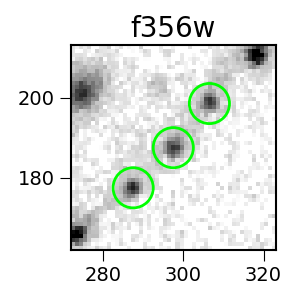

6.697306667568865 observed flux

6.697306611673559 model flux
4.909516597255471 model amplitude
57.61667171993277 nJy
26.998629581878667 mag(AB)

6.697306884299445 model flux
5.6362040687394135 model amplitude
66.14486643280617 nJy
26.848759640460607 mag(AB)


In [16]:
x, y = 595, 374  # Earendel
filt = 'f356w'
lam = extract_lam(filt)
if lam > 2.4:
    x = roundint(x / 2) - 1
    y = roundint(y / 2)

ifilt = filters.index(filt)
ee = PSF_ees[ifilt]

plot_slices, plot_extent = slices_extent(x, y, 25)

fig, ax = plt.subplots(1, 1, figsize=(3,3))#, sharex=True, sharey=True)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
data = fits.getdata(image_files[filt])
#plt.imshow(data[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')

r_pix = 5
aperture = CircularAperture((x+0.5, y+0.5), r_pix)
aperture.plot(color=(0,1,0), lw=2)
aperture_stats = ApertureStats(data, aperture)
observed_flux = aperture_stats.sum
print(observed_flux, 'observed flux')
print()

# Add fake source
data_plus_model = data + 0

PSF_data = fits.getdata(PSF_files[filt])

xoffset, yoffset = 9, 11
x2, y2 = x+xoffset, y+yoffset
aperture = CircularAperture((x2+0.5, y2+0.5), r_pix)
PSF_slices, PSF_extent = slices_extent(x2, y2, 11)
#fit_flux = 50  # nJy
#print(fit_flux)
fit_flux = optimize.golden(flux_difference, brack=[0, 100])
fit_amplitude = fit_flux / 10. * ee
data_plus_model[PSF_slices] = data[PSF_slices] + PSF_data * fit_amplitude
aperture.plot(color=(0,1,0), lw=2)
aperture_stats = ApertureStats(data_plus_model, aperture)
model_flux = aperture_stats.sum
print(model_flux, 'model flux')
print(fit_amplitude, 'model amplitude')
print(fit_flux, 'nJy')
print((fit_flux * u.nJy).to(u.ABmag))
print()


xoffset, yoffset = -10, -10
x2, y2 = x+xoffset, y+yoffset
aperture = CircularAperture((x2+0.5, y2+0.5), r_pix)
PSF_slices, PSF_extent = slices_extent(x2, y2, 11)
#fit_flux = 50  # nJy
#print(fit_flux)
fit_flux = optimize.golden(flux_difference, brack=[0, 100])
fit_amplitude = fit_flux / 10. * ee
data_plus_model[PSF_slices] = data[PSF_slices] + PSF_data * fit_amplitude
aperture.plot(color=(0,1,0), lw=2)
aperture_stats = ApertureStats(data_plus_model, aperture)
model_flux = aperture_stats.sum
print(model_flux, 'model flux')
print(fit_amplitude, 'model amplitude')
print(fit_flux, 'nJy')
print((fit_flux * u.nJy).to(u.ABmag))

plt.title(filt)

plt.imshow(data_plus_model[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')

#plt.savefig('Earendel_clones_%s.png' % filt)

<IPython.core.display.Javascript object>


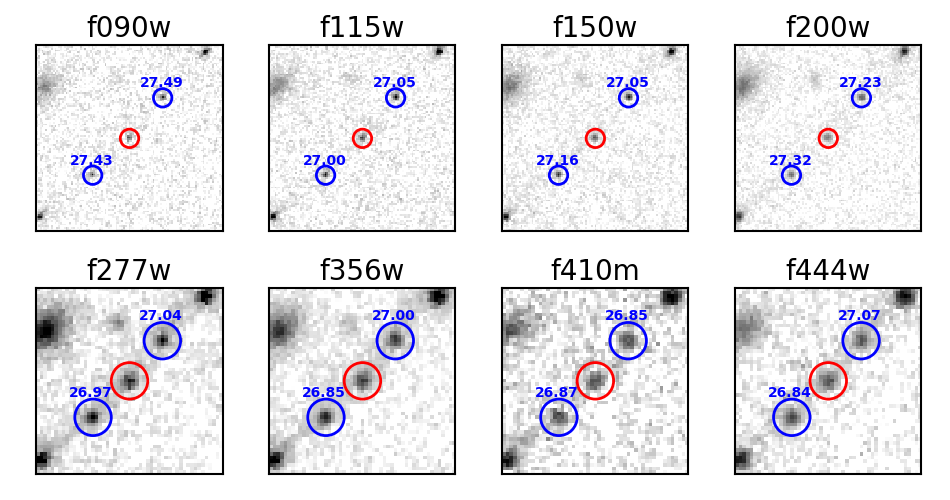

In [17]:
nimages = len(filters)
nrows = 2
ncolumns = nimages // nrows

fig, axs = plt.subplots(nrows, ncolumns, figsize=(9.5,5)) #, sharex=True, sharey=True)

all_mags = []
for i, filt in enumerate(filters):
    iy = i // ncolumns
    ix = i %  ncolumns
    ax = axs[iy,ix]

    x, y = 595, 374  # Earendel
    lam = extract_lam(filt)
    if lam > 2.4:
        x = roundint(x / 2) - 1
        y = roundint(y / 2)

    ifilt = filters.index(filt)
    ee = PSF_ees[ifilt]

    plot_dx = 25
    r_pix = 5
    if lam < 2.4:
        plot_dx *= 2
        #r_pix *= 2
    
    plot_slices, plot_extent = slices_extent(x, y, plot_dx)

    norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
    data = fits.getdata(image_files[filt])
    #plt.imshow(data[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')


    aperture = CircularAperture((x+0.5, y+0.5), r_pix)
    aperture.plot(ax, color='r', lw=2)
    aperture_stats = ApertureStats(data, aperture)
    observed_flux = aperture_stats.sum
    #print(observed_flux, 'observed flux')
    #print()

    # Add fake source
    data_plus_model = data + 0

    PSF_data = fits.getdata(PSF_files[filt])

    filt_mags = []
    for offsets in ((9,11), (-10,-10)):
        xoffset, yoffset = offsets
        if lam < 2.4:
            xoffset *= 2
            yoffset *= 2

        x2, y2 = x+xoffset, y+yoffset
        aperture = CircularAperture((x2+0.5, y2+0.5), r_pix)
        PSF_slices, PSF_extent = slices_extent(x2, y2, 11)
        fit_flux = optimize.golden(flux_difference, brack=[0, 100])
        fit_mag = (fit_flux * u.nJy).to(u.ABmag)
        fit_amplitude = fit_flux / 10. * ee
        data_plus_model[PSF_slices] = data[PSF_slices] + PSF_data * fit_amplitude
        aperture.plot(ax, color='b', lw=2)
        aperture_stats = ApertureStats(data_plus_model, aperture)
        model_flux = aperture_stats.sum
        ax.text(x2, y2+r_pix+1.2, '%5.2f' % fit_mag.value, ha='center', weight='bold', color='b')
        filt_mags.append(fit_mag.value)

    all_mags.append(filt_mags)
    ax.set_title(filt)

    ax.imshow(data_plus_model[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#plt.savefig('Earendel_clones.png')

In [18]:
all_mags = np.array(all_mags)
all_mags.sort(axis=1)
all_mags.T

array([[27.43163418, 27.00489298, 27.054602  , 27.22681823, 26.96872855,
        26.84875964, 26.85305439, 26.84052249],
       [27.4937582 , 27.05179915, 27.16226802, 27.31583997, 27.0365731 ,
        26.99862958, 26.86682252, 27.07060048]])

<IPython.core.display.Javascript object>


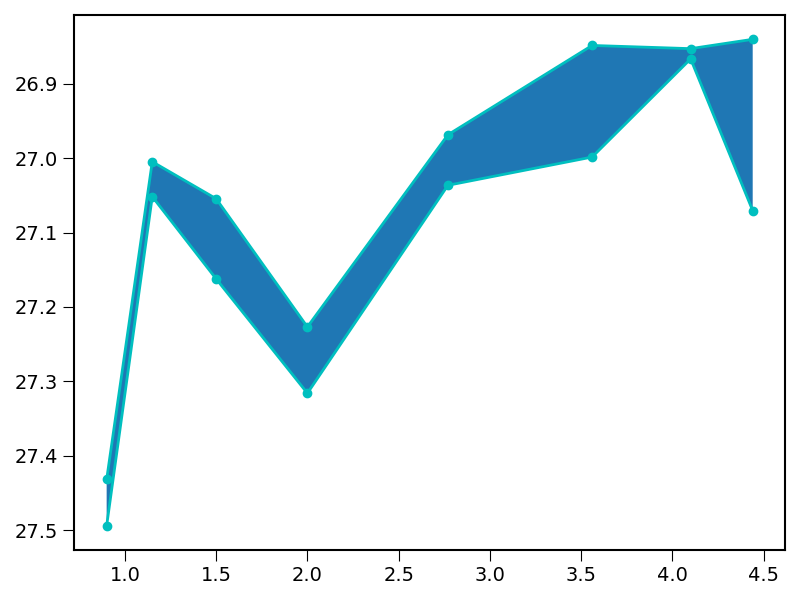

(27.526419982078867, 26.80786070451847)

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) #, sharex=True, sharey=True)
plt.fill_between(lams, all_mags[:,0], all_mags[:,1])
plt.plot(lams, all_mags[:,0], 'co-')
plt.plot(lams, all_mags[:,1], 'co-')
plt.ylim(plt.ylim()[::-1])

# Initial attempt: offsets by a fixed number pixels

But this analyzes different portions of the arc in short and long wavelength channel. Could introduce bias.

<IPython.core.display.Javascript object>


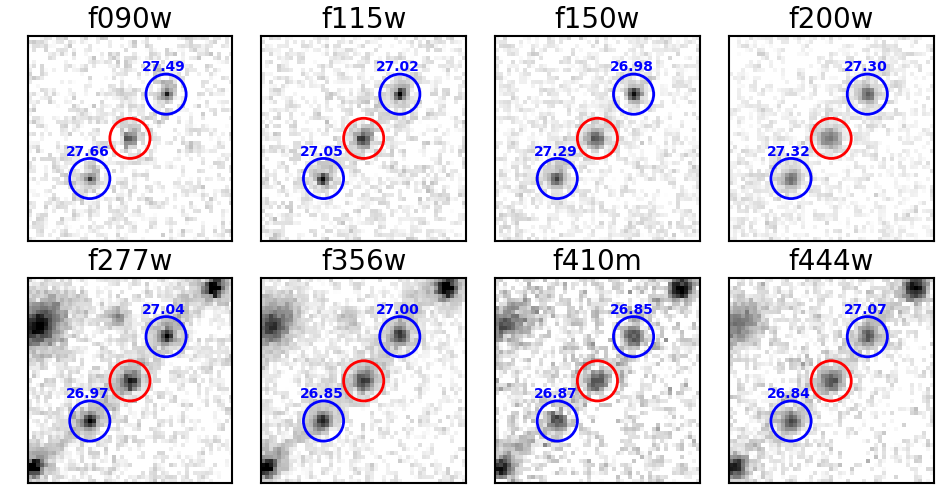

In [20]:
nimages = len(filters)
nrows = 2
ncolumns = nimages // nrows

fig, axs = plt.subplots(nrows, ncolumns, figsize=(9.5,5)) #, sharex=True, sharey=True)

for i, filt in enumerate(filters):
    iy = i // ncolumns
    ix = i %  ncolumns
    ax = axs[iy,ix]

    x, y = 595, 374  # Earendel
    lam = extract_lam(filt)
    if lam > 2.4:
        x = roundint(x / 2) - 1
        y = roundint(y / 2)

    ifilt = filters.index(filt)
    ee = PSF_ees[ifilt]

    plot_slices, plot_extent = slices_extent(x, y, 25)

    norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
    data = fits.getdata(image_files[filt])
    #plt.imshow(data[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')

    r_pix = 5
    aperture = CircularAperture((x+0.5, y+0.5), r_pix)
    aperture.plot(ax, color='r', lw=2)
    aperture_stats = ApertureStats(data, aperture)
    observed_flux = aperture_stats.sum
    #print(observed_flux, 'observed flux')
    #print()

    # Add fake source
    data_plus_model = data + 0

    PSF_data = fits.getdata(PSF_files[filt])

    for offsets in ((9,11), (-10,-10)):
        xoffset, yoffset = offsets
        x2, y2 = x+xoffset, y+yoffset
        aperture = CircularAperture((x2+0.5, y2+0.5), r_pix)
        PSF_slices, PSF_extent = slices_extent(x2, y2, 11)
        fit_flux = optimize.golden(flux_difference, brack=[0, 100])
        fit_mag = (fit_flux * u.nJy).to(u.ABmag)
        fit_amplitude = fit_flux / 10. * ee
        data_plus_model[PSF_slices] = data[PSF_slices] + PSF_data * fit_amplitude
        aperture.plot(ax, color='b', lw=2)
        aperture_stats = ApertureStats(data_plus_model, aperture)
        model_flux = aperture_stats.sum
        ax.text(x2, y2+r_pix+1.2, '%5.2f' % fit_mag.value, ha='center', weight='bold', color='b')

    ax.set_title(filt)

    ax.imshow(data_plus_model[plot_slices], extent=plot_extent, origin='lower', interpolation='none', norm=norm, cmap='Greys')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.savefig('Earendel_clones_%s.png' % filt)